# Credit Score Classification Project

## Problem Statement
You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate people into credit score brackets to reduce manual efforts.

## Task
Given a person's credit-related information, build a machine learning model that can classify the credit score.

### Target Variable
- **Credit_Score**: The target variable with three categories:
  - Good
  - Standard  
  - Poor

Let's build a comprehensive machine learning solution!

## 1. Import Required Libraries

Let's start by importing all the necessary libraries for our analysis:

In [ ]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer

# Additional ML libraries
import xgboost as xgb
import lightgbm as lgb

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Dataset

Let's load our training and test datasets and examine their structure:

In [ ]:
# Load the datasets
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("\n" + "="*50)

print("\nTraining Data Info:")
print("Columns:", list(train_data.columns))
print("\nFirst few rows of training data:")
print(train_data.head())

print("\n" + "="*50)
print("\nData Types:")
print(train_data.dtypes)

Training Data Shape: (100000, 28)
Test Data Shape: (50000, 27)


Training Data Info:
Columns: ['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']

First few rows of training data:
       ID Customer_ID     Month           Name   Age          SSN Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate Num_of_Loan                                       Type_of_Loan  Delay_from_due_date Num_of_Delayed_Payment Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix Outstanding_Debt  Credit_Utilization_

Credit Score Distribution:
Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

Credit Score Distribution (%):
Credit_Score
Standard    53.174
Poor        28.998
Good        17.828
Name: proportion, dtype: float64


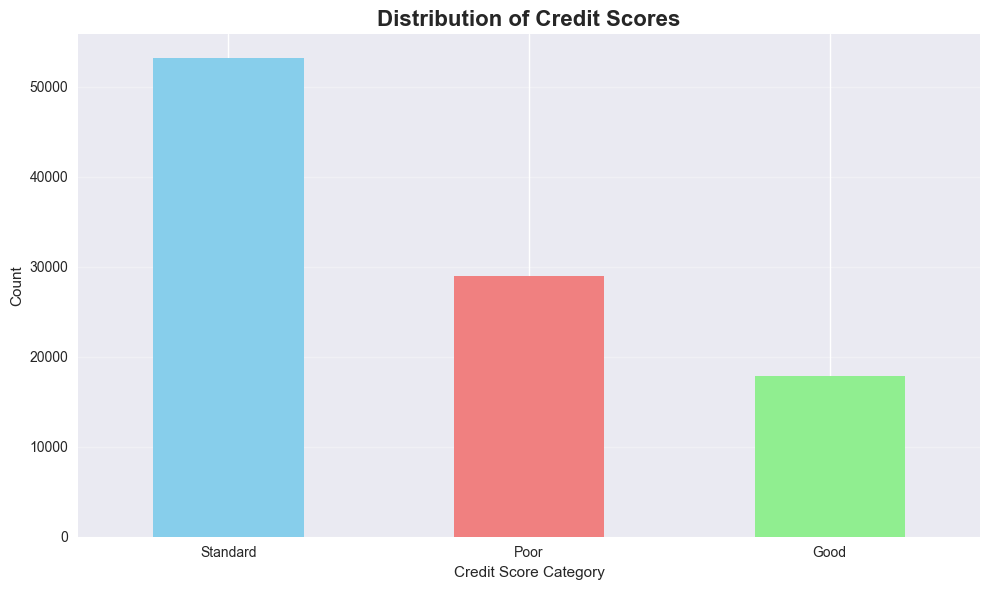

In [ ]:
# Check target variable distribution
print("Credit Score Distribution:")
print(train_data['Credit_Score'].value_counts())
print("\nCredit Score Distribution (%):")
print(train_data['Credit_Score'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(10, 6))
train_data['Credit_Score'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Credit Scores', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Basic statistics and missing values analysis
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

print("\nTraining Data Missing Values:")
missing_train = train_data.isnull().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False))

print("\nTest Data Missing Values:")
missing_test = test_data.isnull().sum()
print(missing_test[missing_test > 0].sort_values(ascending=False))

print("\n" + "="*60)
print("BASIC STATISTICS FOR NUMERICAL COLUMNS")
print("="*60)
print(train_data.describe())

MISSING VALUES ANALYSIS

Training Data Missing Values:
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Name                        9985
Credit_History_Age          9030
Num_of_Delayed_Payment      7002
Amount_invested_monthly     4479
Num_Credit_Inquiries        1965
Monthly_Balance             1200
dtype: int64

Test Data Missing Values:
Monthly_Inhand_Salary      7498
Type_of_Loan               5704
Name                       5015
Credit_History_Age         4470
Num_of_Delayed_Payment     3498
Amount_invested_monthly    2271
Num_Credit_Inquiries       1035
Monthly_Balance             562
dtype: int64

BASIC STATISTICS FOR NUMERICAL COLUMNS
       Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Delay_from_due_date  Num_Credit_Inquiries  Credit_Utilization_Ratio  Total_EMI_per_month
count           84998.000000      100000.000000     100000.00000  100000.000000        100000.000000          98035.000000             100000.000000        100000

## 3. Data Preprocessing and Cleaning

Now let's clean the data by handling missing values, correcting data types, and fixing inconsistent entries:

In [ ]:
def clean_data(df):
    """
    Clean and preprocess the dataset
    """
    df_clean = df.copy()
    
    # 1. Clean Age column - remove negative values and non-numeric entries
    df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')
    df_clean['Age'] = df_clean['Age'].apply(lambda x: x if x > 0 and x < 100 else np.nan)
    
    # 2. Clean Annual_Income - remove non-numeric entries
    df_clean['Annual_Income'] = pd.to_numeric(df_clean['Annual_Income'], errors='coerce')
    df_clean['Annual_Income'] = df_clean['Annual_Income'].apply(lambda x: x if x > 0 else np.nan)
    
    # 3. Clean Monthly_Inhand_Salary
    df_clean['Monthly_Inhand_Salary'] = pd.to_numeric(df_clean['Monthly_Inhand_Salary'], errors='coerce')
    
    # 4. Clean Num_Bank_Accounts - handle non-numeric values
    df_clean['Num_Bank_Accounts'] = pd.to_numeric(df_clean['Num_Bank_Accounts'], errors='coerce')
    df_clean['Num_Bank_Accounts'] = df_clean['Num_Bank_Accounts'].apply(lambda x: x if x >= 0 and x < 50 else np.nan)
    
    # 5. Clean Num_Credit_Card
    df_clean['Num_Credit_Card'] = pd.to_numeric(df_clean['Num_Credit_Card'], errors='coerce')
    df_clean['Num_Credit_Card'] = df_clean['Num_Credit_Card'].apply(lambda x: x if x >= 0 and x < 50 else np.nan)
    
    # 6. Clean Interest_Rate
    df_clean['Interest_Rate'] = pd.to_numeric(df_clean['Interest_Rate'], errors='coerce')
    
    # 7. Clean Num_of_Loan
    df_clean['Num_of_Loan'] = pd.to_numeric(df_clean['Num_of_Loan'], errors='coerce')
    df_clean['Num_of_Loan'] = df_clean['Num_of_Loan'].apply(lambda x: x if x >= 0 and x < 30 else np.nan)
    
    # 8. Clean Delay_from_due_date
    df_clean['Delay_from_due_date'] = pd.to_numeric(df_clean['Delay_from_due_date'], errors='coerce')
    
    # 9. Clean Num_of_Delayed_Payment - handle string entries with '_'
    df_clean['Num_of_Delayed_Payment'] = df_clean['Num_of_Delayed_Payment'].astype(str).str.replace('_', '')
    df_clean['Num_of_Delayed_Payment'] = pd.to_numeric(df_clean['Num_of_Delayed_Payment'], errors='coerce')
    
    # 10. Clean Changed_Credit_Limit
    df_clean['Changed_Credit_Limit'] = pd.to_numeric(df_clean['Changed_Credit_Limit'], errors='coerce')
    
    # 11. Clean Num_Credit_Inquiries
    df_clean['Num_Credit_Inquiries'] = pd.to_numeric(df_clean['Num_Credit_Inquiries'], errors='coerce')
    
    # 12. Clean Credit_Mix - standardize categories
    df_clean['Credit_Mix'] = df_clean['Credit_Mix'].replace('_', 'Bad')
    df_clean['Credit_Mix'] = df_clean['Credit_Mix'].fillna('Standard')
    
    # 13. Clean Outstanding_Debt
    df_clean['Outstanding_Debt'] = pd.to_numeric(df_clean['Outstanding_Debt'], errors='coerce')
    
    # 14. Clean Credit_Utilization_Ratio
    df_clean['Credit_Utilization_Ratio'] = pd.to_numeric(df_clean['Credit_Utilization_Ratio'], errors='coerce')
    
    # 15. Clean Credit_History_Age - extract numeric years
    df_clean['Credit_History_Age_Years'] = df_clean['Credit_History_Age'].str.extract('(\d+)').astype(float)
    
    # 16. Clean Payment_of_Min_Amount
    df_clean['Payment_of_Min_Amount'] = df_clean['Payment_of_Min_Amount'].replace(['NM', 'nm'], 'No')
    df_clean['Payment_of_Min_Amount'] = df_clean['Payment_of_Min_Amount'].fillna('No')
    
    # 17. Clean Total_EMI_per_month
    df_clean['Total_EMI_per_month'] = pd.to_numeric(df_clean['Total_EMI_per_month'], errors='coerce')
    
    # 18. Clean Amount_invested_monthly - handle special values like '__10000__'
    df_clean['Amount_invested_monthly'] = df_clean['Amount_invested_monthly'].astype(str)
    df_clean['Amount_invested_monthly'] = df_clean['Amount_invested_monthly'].str.replace('__', '').str.replace('_', '')
    df_clean['Amount_invested_monthly'] = pd.to_numeric(df_clean['Amount_invested_monthly'], errors='coerce')
    
    # 19. Clean Payment_Behaviour - handle special characters
    df_clean['Payment_Behaviour'] = df_clean['Payment_Behaviour'].str.replace('!@9#%8', 'Low_spent_Small_value_payments')
    
    # 20. Clean Monthly_Balance
    df_clean['Monthly_Balance'] = pd.to_numeric(df_clean['Monthly_Balance'], errors='coerce')
    
    # 21. Clean SSN and other identifier columns - handle special characters
    df_clean['SSN'] = df_clean['SSN'].str.replace('#F%$D@*&8', '')
    df_clean['Occupation'] = df_clean['Occupation'].str.replace('_______', 'Unknown')
    
    return df_clean

# Apply cleaning to both datasets
print("Cleaning training data...")
train_clean = clean_data(train_data)

print("Cleaning test data...")
test_clean = clean_data(test_data)

print("Data cleaning completed!")

Cleaning training data...
Cleaning test data...
Data cleaning completed!


In [ ]:
# Check the results of cleaning
print("After Cleaning - Missing Values in Training Data:")
missing_after = train_clean.isnull().sum()
print(missing_after[missing_after > 0].sort_values(ascending=False))

print("\nAfter Cleaning - Data Types:")
print(train_clean.dtypes)

print("\nCleaned Credit Score Distribution:")
print(train_clean['Credit_Score'].value_counts())

After Cleaning - Missing Values in Training Data:
Monthly_Inhand_Salary       15002
Type_of_Loan                11408
Name                         9985
Num_of_Loan                  9102
Credit_History_Age           9030
Credit_History_Age_Years     9030
Age                          7631
Num_of_Delayed_Payment       7002
Annual_Income                6980
Amount_invested_monthly      4479
Num_Credit_Card              2215
Changed_Credit_Limit         2091
Num_Credit_Inquiries         1965
Num_Bank_Accounts            1302
Monthly_Balance              1209
Outstanding_Debt             1009
dtype: int64

After Cleaning - Data Types:
ID                              str
Customer_ID                     str
Month                           str
Name                            str
Age                         float64
SSN                             str
Occupation                      str
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num

## 4. Exploratory Data Analysis

Let's explore the relationships between features and the target variable:

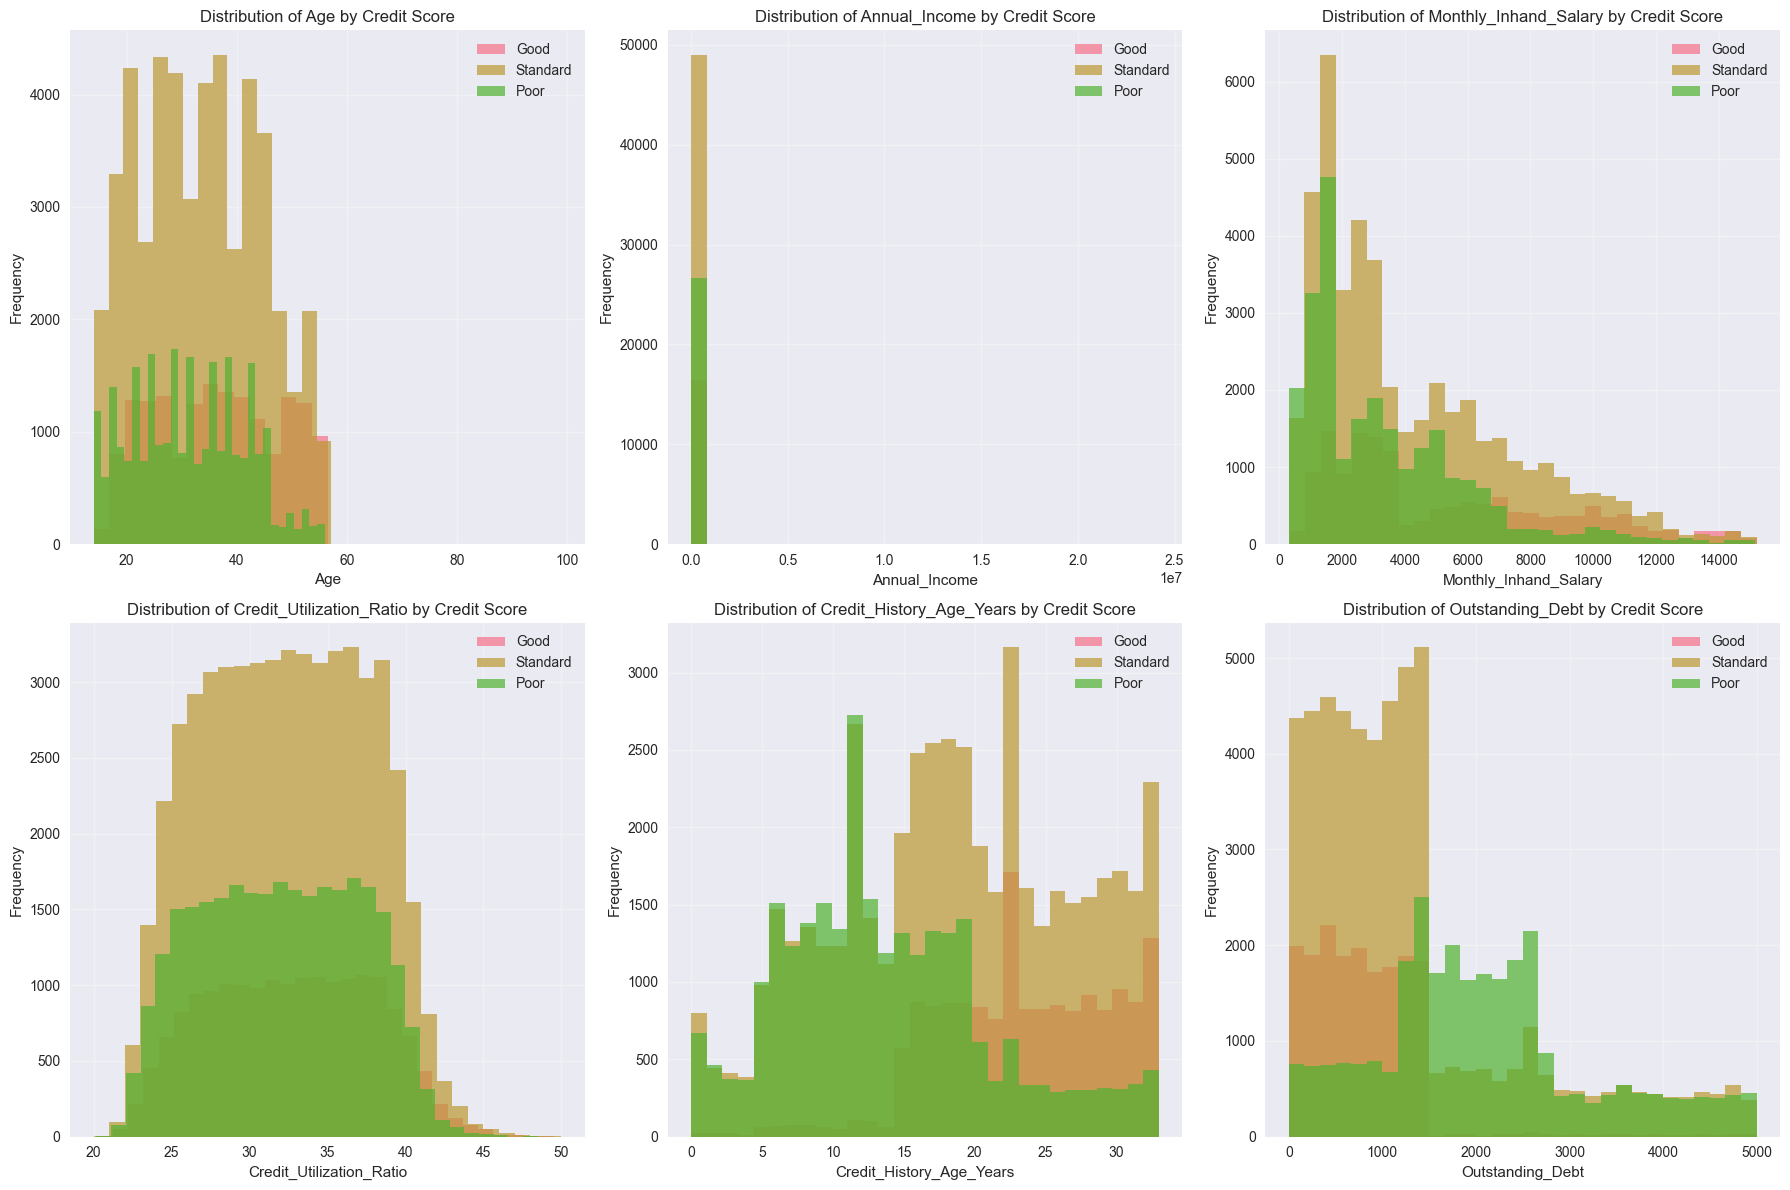

In [ ]:
# Visualize distributions of key numerical features by credit score
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

numerical_features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 
                     'Credit_Utilization_Ratio', 'Credit_History_Age_Years', 'Outstanding_Debt']

for idx, feature in enumerate(numerical_features):
    if feature in train_clean.columns:
        for score in train_clean['Credit_Score'].unique():
            if pd.notna(score):
                data = train_clean[train_clean['Credit_Score'] == score][feature].dropna()
                axes[idx].hist(data, alpha=0.7, label=f'{score}', bins=30)
        axes[idx].set_title(f'Distribution of {feature} by Credit Score')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

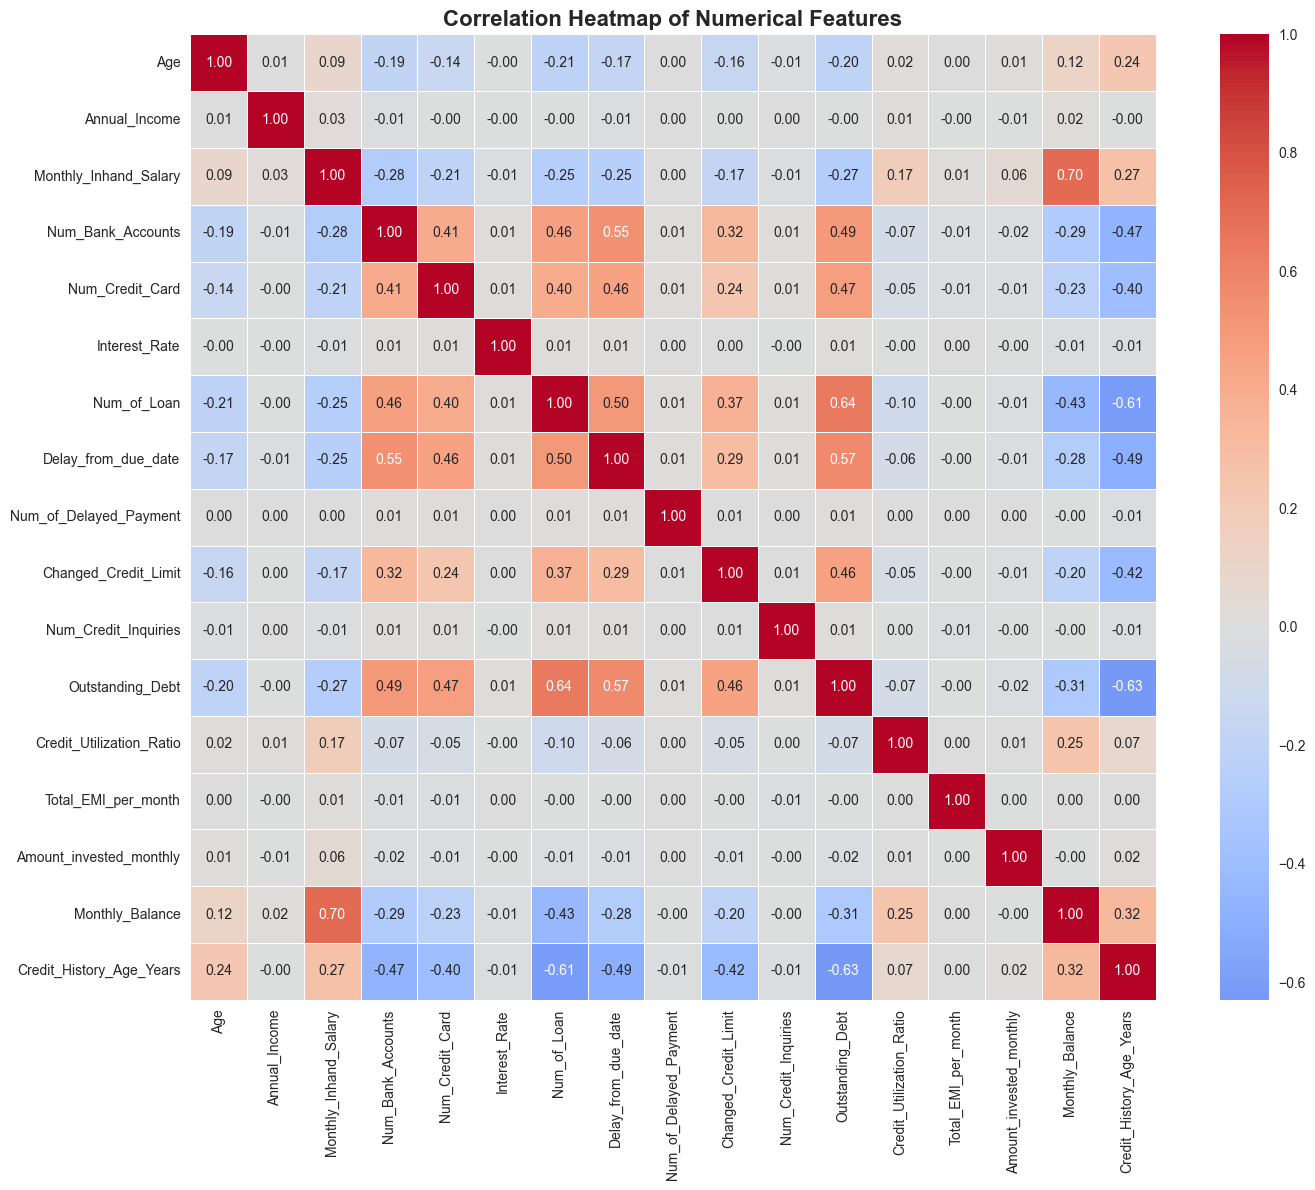

In [ ]:
# Correlation heatmap for numerical features
plt.figure(figsize=(15, 12))

# Select numerical columns for correlation
numerical_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['ID', 'Customer_ID']]

# Calculate correlation matrix
correlation_matrix = train_clean[numerical_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

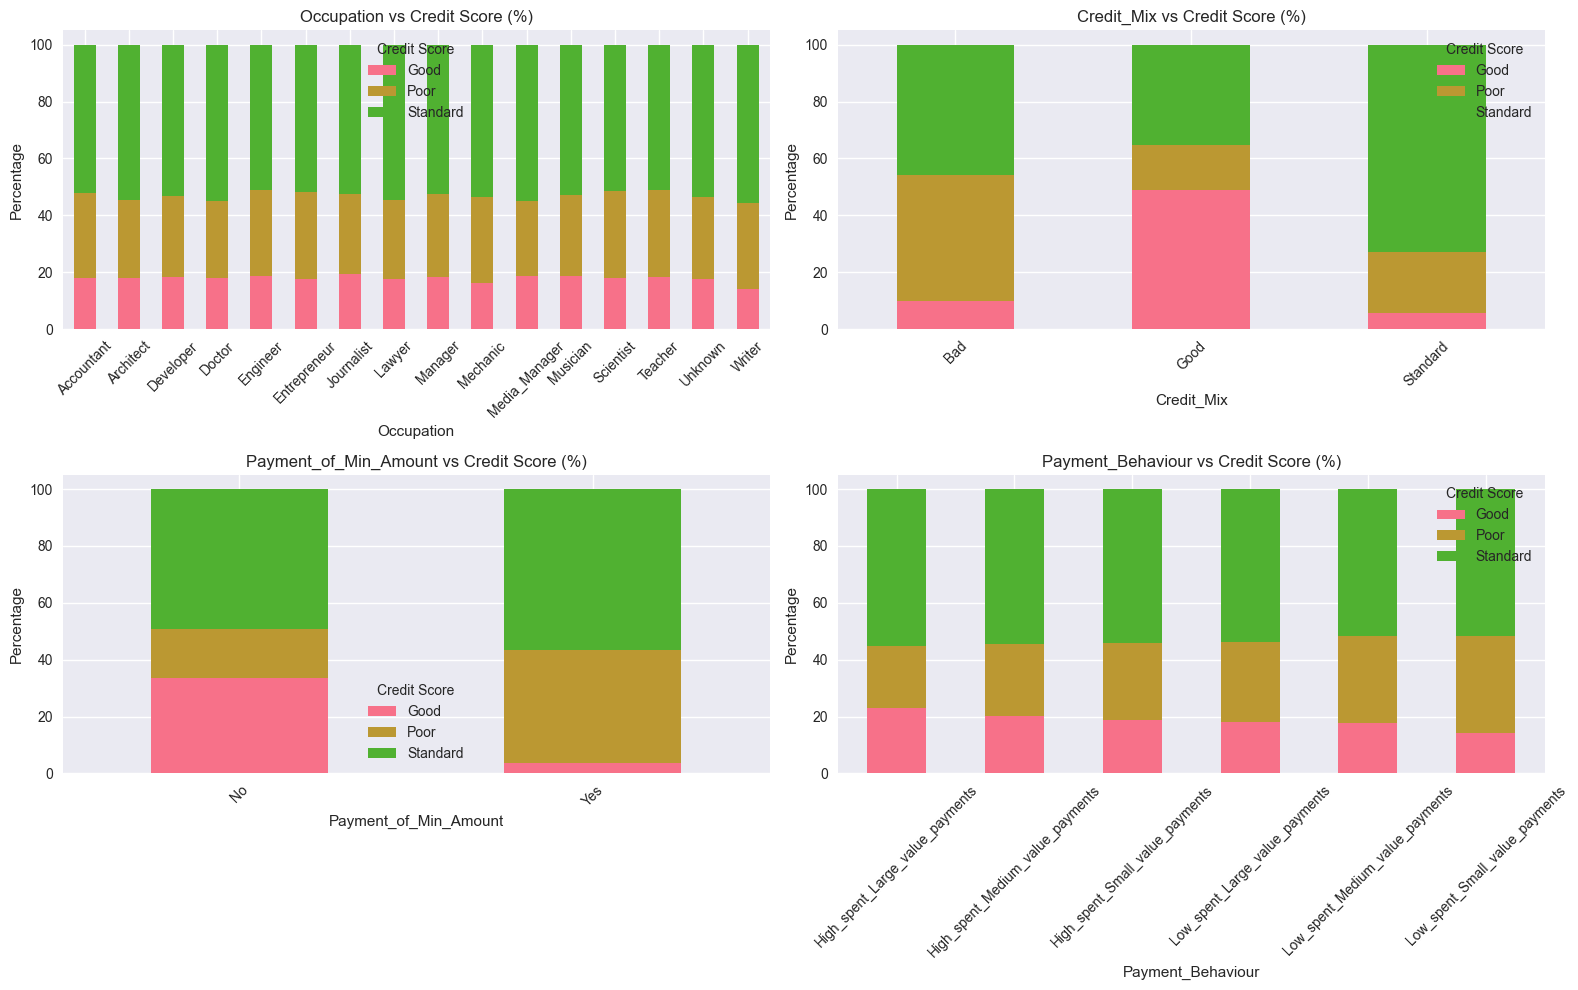

In [ ]:
# Analyze categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

categorical_features = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

for idx, feature in enumerate(categorical_features):
    if feature in train_clean.columns:
        # Create crosstab
        ct = pd.crosstab(train_clean[feature], train_clean['Credit_Score'], normalize='index') * 100
        ct.plot(kind='bar', ax=axes[idx], stacked=True)
        axes[idx].set_title(f'{feature} vs Credit Score (%)')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(title='Credit Score')
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Feature Engineering

Now let's prepare our features for machine learning by encoding categorical variables and scaling numerical features:

In [ ]:
def prepare_features(df, is_training=True):
    """
    Prepare features for machine learning
    """
    df_processed = df.copy()
    
    # Select features for modeling (exclude ID columns, names, etc.)
    features_to_exclude = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month', 'Credit_History_Age']
    if is_training:
        features_to_exclude.append('Credit_Score')
    
    # Select relevant features
    feature_columns = [col for col in df_processed.columns if col not in features_to_exclude]
    
    # Create feature matrix
    X = df_processed[feature_columns].copy()
    
    # Handle missing values for numerical columns
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numerical_cols:
        X[col] = X[col].fillna(X[col].median())
    
    # Handle categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols:
        X[col] = X[col].fillna('Unknown')
    
    # Create binary features from categorical variables
    for col in categorical_cols:
        if col in X.columns:
            # Get top categories to avoid too many features
            top_categories = X[col].value_counts().head(10).index.tolist()
            
            # Create binary features for top categories
            for category in top_categories:
                X[f'{col}_{category}'] = (X[col] == category).astype(int)
    
    # Drop original categorical columns
    X = X.drop(columns=categorical_cols)
    
    # Feature engineering - create new features
    if 'Annual_Income' in X.columns and 'Monthly_Inhand_Salary' in X.columns:
        X['Income_Salary_Ratio'] = X['Annual_Income'] / (X['Monthly_Inhand_Salary'] * 12 + 1)
    
    if 'Outstanding_Debt' in X.columns and 'Annual_Income' in X.columns:
        X['Debt_Income_Ratio'] = X['Outstanding_Debt'] / (X['Annual_Income'] + 1)
    
    if 'Total_EMI_per_month' in X.columns and 'Monthly_Inhand_Salary' in X.columns:
        X['EMI_Salary_Ratio'] = X['Total_EMI_per_month'] / (X['Monthly_Inhand_Salary'] + 1)
    
    if 'Num_Credit_Card' in X.columns and 'Num_Bank_Accounts' in X.columns:
        X['Credit_Bank_Ratio'] = X['Num_Credit_Card'] / (X['Num_Bank_Accounts'] + 1)
    
    # Replace infinite values with 0
    X = X.replace([np.inf, -np.inf], 0)
    
    return X

# Prepare features for training data
X_train_processed = prepare_features(train_clean, is_training=True)
y_train = train_clean['Credit_Score'].copy()

# Prepare features for test data
X_test_processed = prepare_features(test_clean, is_training=False)

print("Feature Engineering Completed!")
print(f"Training features shape: {X_train_processed.shape}")
print(f"Test features shape: {X_test_processed.shape}")
print(f"Features: {list(X_train_processed.columns[:10])}...")  # Show first 10 features

Feature Engineering Completed!
Training features shape: (100000, 52)
Test features shape: (50000, 52)
Features: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit']...


## 6. Data Splitting

Let's split the training data into training and validation sets:

In [ ]:
# Ensure test features have the same columns as training features
# Get common columns between training and test sets
common_features = list(set(X_train_processed.columns) & set(X_test_processed.columns))
print(f"Common features: {len(common_features)}")

# Align feature sets
X_train_aligned = X_train_processed[common_features]
X_test_aligned = X_test_processed[common_features]

# Split the training data
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_aligned, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print("Data Split Completed!")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training target distribution:")
print(y_train_split.value_counts())
print(f"Validation target distribution:")
print(y_val.value_counts())

Common features: 52
Data Split Completed!
Training set shape: (80000, 52)
Validation set shape: (20000, 52)
Training target distribution:
Credit_Score
Standard    42539
Poor        23199
Good        14262
Name: count, dtype: int64
Validation target distribution:
Credit_Score
Standard    10635
Poor         5799
Good         3566
Name: count, dtype: int64


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_aligned)

print("Feature scaling completed!")

Feature scaling completed!


## 7. Model Training and Selection

Let's train multiple machine learning models and compare their performance:

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# Encode target labels for models that require numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_split)
y_val_encoded = label_encoder.transform(y_val)

# Train and evaluate models
model_results = {}

print("Training Multiple Models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    if name in ['Logistic Regression']:
        # Use encoded labels for logistic regression with scaled features
        model.fit(X_train_scaled, y_train_encoded)
        val_predictions_encoded = model.predict(X_val_scaled)
        val_probabilities = model.predict_proba(X_val_scaled)
        # Convert back to original labels
        val_predictions = label_encoder.inverse_transform(val_predictions_encoded)
    elif name in ['XGBoost', 'LightGBM']:
        # Use encoded labels for XGBoost and LightGBM
        model.fit(X_train, y_train_encoded)
        val_predictions_encoded = model.predict(X_val)
        val_probabilities = model.predict_proba(X_val)
        # Convert back to original labels
        val_predictions = label_encoder.inverse_transform(val_predictions_encoded)
    else:
        # Use original string labels for tree-based models
        model.fit(X_train, y_train_split)
        val_predictions = model.predict(X_val)
        val_probabilities = model.predict_proba(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    
    # Store results
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': val_predictions,
        'probabilities': val_probabilities,
        'label_encoder': label_encoder if name in ['XGBoost', 'LightGBM', 'Logistic Regression'] else None
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

print("\n" + "=" * 50)
print("Model Training Completed!")

Training Multiple Models...

Training Random Forest...
Random Forest - Accuracy: 0.7843, F1-Score: 0.7843

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.7039, F1-Score: 0.7035

Training Logistic Regression...
Logistic Regression - Accuracy: 0.6352, F1-Score: 0.6303

Training XGBoost...
XGBoost - Accuracy: 0.7533, F1-Score: 0.7534

Training LightGBM...
LightGBM - Accuracy: 0.7294, F1-Score: 0.7298

Model Training Completed!


## 8. Model Evaluation

Let's evaluate and compare the performance of all our models:

Model Performance Comparison:
                 Model  Accuracy  F1-Score
0        Random Forest   0.78435  0.784334
3              XGBoost   0.75335  0.753432
4             LightGBM   0.72935  0.729752
1    Gradient Boosting   0.70390  0.703455
2  Logistic Regression   0.63520  0.630270


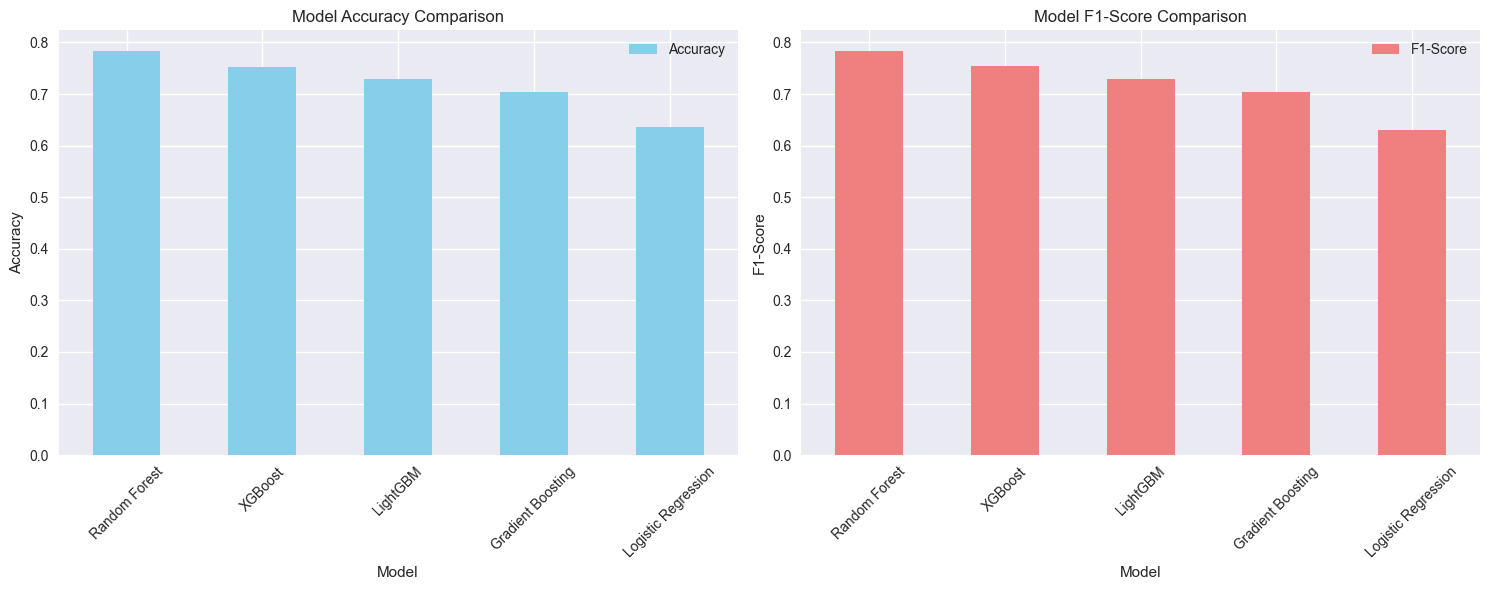


Best performing model: Random Forest
Best F1-Score: 0.7843


In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'F1-Score': [results['f1_score'] for results in model_results.values()]
})

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("Model Performance Comparison:")
print(comparison_df)

# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# F1-Score comparison
comparison_df.plot(x='Model', y='F1-Score', kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Model F1-Score Comparison')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Get the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")

Detailed Evaluation for Random Forest

Classification Report:
              precision    recall  f1-score   support

        Good       0.73      0.73      0.73      3566
        Poor       0.78      0.79      0.78      5799
    Standard       0.80      0.80      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.78      0.78      0.78     20000



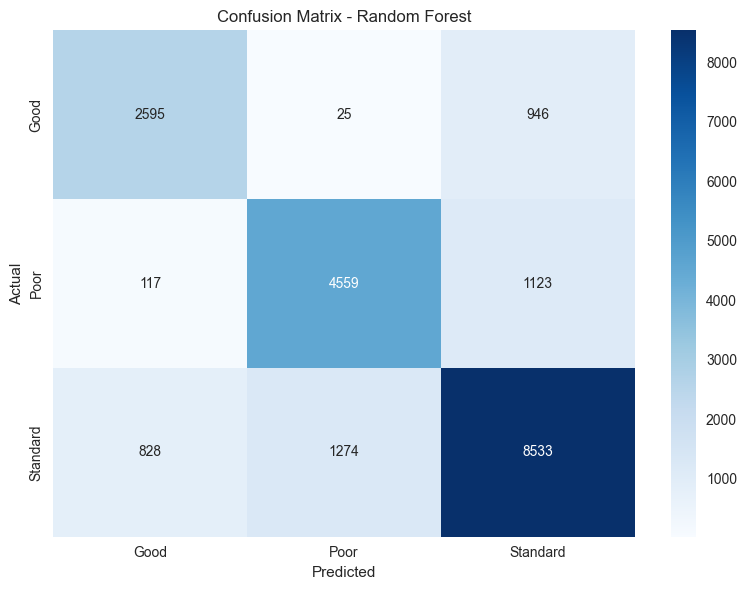

In [ ]:
# Detailed evaluation of the best model
best_predictions = model_results[best_model_name]['predictions']

print(f"Detailed Evaluation for {best_model_name}")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, best_predictions))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], 
            yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

Let's analyze which features are most important for credit score prediction:

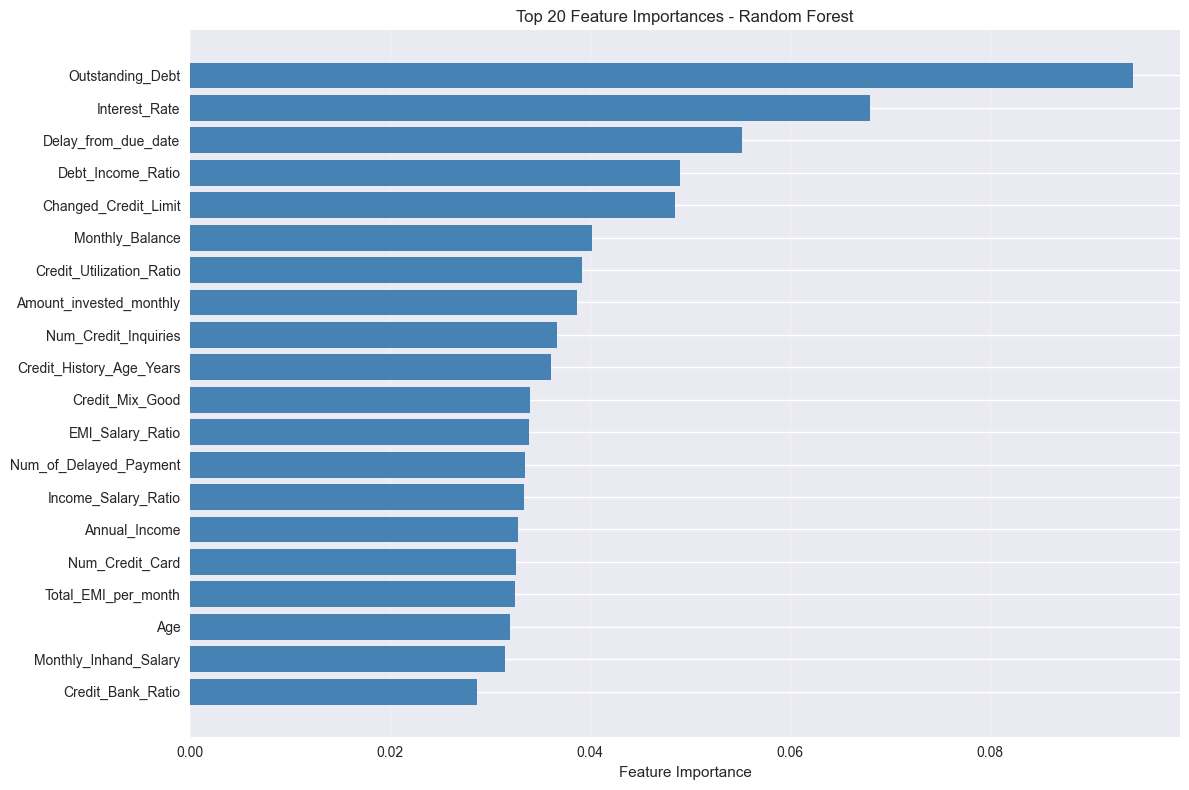

Top 10 Most Important Features:
                     Feature  Importance
42          Outstanding_Debt    0.094276
25             Interest_Rate    0.067941
14       Delay_from_due_date    0.055152
37         Debt_Income_Ratio    0.048993
43      Changed_Credit_Limit    0.048507
33           Monthly_Balance    0.040193
22  Credit_Utilization_Ratio    0.039205
21   Amount_invested_monthly    0.038682
38      Num_Credit_Inquiries    0.036685
36  Credit_History_Age_Years    0.036038


In [ ]:
# Feature importance analysis for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importances = best_model.feature_importances_
    feature_names = common_features
    
    # Create dataframe for feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))
else:
    print(f"Feature importance not available for {best_model_name}")
    
    # For logistic regression, we can look at coefficient magnitudes
    if hasattr(best_model, 'coef_'):
        coefficients = np.abs(best_model.coef_).mean(axis=0)  # Average across classes
        
        importance_df = pd.DataFrame({
            'Feature': common_features,
            'Coefficient_Magnitude': coefficients
        }).sort_values('Coefficient_Magnitude', ascending=False)
        
        print("Top 10 Features by Coefficient Magnitude:")
        print(importance_df.head(10))

## 10. Model Prediction on Test Data

Finally, let's apply our best model to make predictions on the test dataset:

In [ ]:
# Make predictions on test data
best_model_info = model_results[best_model_name]
model = best_model_info['model']
label_enc = best_model_info['label_encoder']

if best_model_name == 'Logistic Regression':
    if label_enc:
        test_predictions_encoded = model.predict(X_test_scaled)
        test_predictions = label_enc.inverse_transform(test_predictions_encoded)
        test_probabilities = model.predict_proba(X_test_scaled)
    else:
        test_predictions = model.predict(X_test_scaled)
        test_probabilities = model.predict_proba(X_test_scaled)
elif best_model_name in ['XGBoost', 'LightGBM']:
    if label_enc:
        test_predictions_encoded = model.predict(X_test_aligned)
        test_predictions = label_enc.inverse_transform(test_predictions_encoded)
        test_probabilities = model.predict_proba(X_test_aligned)
    else:
        test_predictions = model.predict(X_test_aligned)
        test_probabilities = model.predict_proba(X_test_aligned)
else:
    test_predictions = model.predict(X_test_aligned)
    test_probabilities = model.predict_proba(X_test_aligned)

# Create results dataframe
results_df = pd.DataFrame({
    'ID': test_clean['ID'],
    'Customer_ID': test_clean['Customer_ID'],
    'Predicted_Credit_Score': test_predictions
})

# Add probability scores
if label_enc and best_model_name in ['XGBoost', 'LightGBM', 'Logistic Regression']:
    # For encoded models, use the original class names
    class_names = label_enc.classes_
else:
    class_names = model.classes_

for i, class_name in enumerate(class_names):
    results_df[f'Probability_{class_name}'] = test_probabilities[:, i]

print("Test Predictions Completed!")
print(f"Total test predictions: {len(results_df)}")
print("\nPredicted Credit Score Distribution:")
print(results_df['Predicted_Credit_Score'].value_counts())
print("\nFirst 10 predictions:")
print(results_df.head(10))

Test Predictions Completed!
Total test predictions: 50000

Predicted Credit Score Distribution:
Predicted_Credit_Score
Standard    26247
Poor        14681
Good         9072
Name: count, dtype: int64

First 10 predictions:
       ID Customer_ID Predicted_Credit_Score  Probability_Good  Probability_Poor  Probability_Standard
0  0x160a   CUS_0xd40                   Good              0.59              0.14                  0.27
1  0x160b   CUS_0xd40                   Good              0.64              0.09                  0.27
2  0x160c   CUS_0xd40                   Good              0.61              0.11                  0.28
3  0x160d   CUS_0xd40                   Good              0.73              0.02                  0.25
4  0x1616  CUS_0x21b1                   Good              0.59              0.09                  0.32
5  0x1617  CUS_0x21b1                   Good              0.75              0.03                  0.22
6  0x1618  CUS_0x21b1               Standard             

Results saved to 'credit_score_predictions.csv'


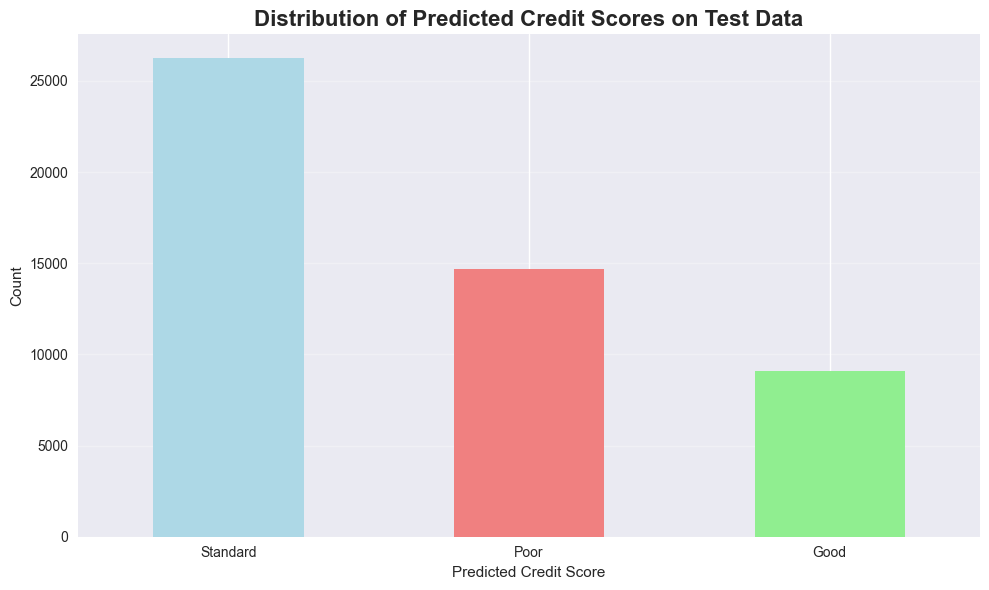


FINAL MODEL SUMMARY
Best Model: Random Forest
Validation Accuracy: 0.7843
Validation F1-Score: 0.7843
Total Features Used: 52
Training Data Size: 100000
Test Predictions Made: 50000


In [ ]:
# Save results to CSV file
results_df.to_csv('credit_score_predictions.csv', index=False)
print("Results saved to 'credit_score_predictions.csv'")

# Visualize prediction distribution
plt.figure(figsize=(10, 6))
results_df['Predicted_Credit_Score'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Predicted Credit Scores on Test Data', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Credit Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
print(f"Validation F1-Score: {model_results[best_model_name]['f1_score']:.4f}")
print(f"Total Features Used: {len(common_features)}")
print(f"Training Data Size: {len(train_clean)}")
print(f"Test Predictions Made: {len(results_df)}")
print("="*60)